<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2:  Ames Housing Data and Kaggle Challenge
---

Problem Statement
---

The Bluth Company, a real estate development firm, wants to develop properties in Ames, Iowa, and they want to find out which features of a property helps increase revenue, and to what extent.

In this project, I will be using housing data from Ames, Iowa, collected between 2006 and 2010 to build a Linear Regression model which we can use to interpret which features affect revenue the most. The model will also be able to predict the sale price of a house after the Bluth Company decides on what features to build.

The model will be evaluated by calculating the Root Mean Squared Error (RMSE). RMSE was chosen because we want to penalise large errors, and also for the value to have the same units as the target variable (Sale Price), e.g. if the RMSE is 20,000, it means the predictions are about \$20,000 away from the actual value. The lower the RMSE, the more accurate the model.

Executive Summary
---

This project is part of a Kaggle challenge. It explores the housing data of Ames, Iowa, for properties sold between 2006 to 2010. The dataset includes information on various features of the property, and some characteristics of each sale.

First, Exploratory Data Analysis (EDA) was performed to explore the relationship between the various data points in the dataset and the sale price. Using the Pearson's correlation coefficient, we identified 11 features that had a strong correlation to the sale price. Upon analysing the data further, we found out that some of the features were strongly correlated to each other, and this would introduce mutlicollinearity into the model training if not corrected. Such features were therefore dropped to prevent multicollinearity. The feature that was dropped from each pair of highly correlated features is the feature that is less strongly correlated to sale price. Missing values were then imputed with the appropriate values and categorical data was dummy encoded.

Next, as the sale price had a positively skewed distribution, we performed a log transformation to normalize the sale price distribution. Thereafter, the data was split into a train set (80% of data) and a test set (20%). We trained 3 models in total, Linear Regression, Ridge Regression and Lasso Regression. The Linear Regression model's scores indicated that it was not suitable for use, and that regularization via Ridge or Lasso was required. Model selection was then done by comparing the 5-fold cross-validated scores and the Root Mean Square Error (RMSE) between the Ridge Regression and Lasso Regression. The Lasso Regression model was selected despite Ridge Regression having a better RMSE, as the Lasso Regression is able to eliminate unimportant features, and also because the Lasso Regression had a higher 5-fold cross-validated score, which likely indicates that it would more representative of future data than Ridge Regression.

The 5 features that positively affected the sale price the most were found to be the above ground living area, overall quality, year built, overall condition and finished basement area. Not a surprising result, as these 5 features were identified earlier during EDA. Recommendations were then made based on the Lasso Regression coefficients of the top 5 and bottom 5 features.

Contents:
---

<ol>
    <li><a href = #data>Data</a>
    <li><a href = #eda>EDA</a>
    <li><a href = #modelling>Modelling</a>
    <li><a href = #eval>Evaluation</a>        
    <li><a href = #conclusion>Conclusion and Recommendation</a>     
    <li><a href = #kaggle>For Kaggle submission</a>     

<a id = "data"></a>

Data
---

In [1]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

sns.set_theme(style="whitegrid")

In [2]:
# Load train data
ames_train = pd.read_csv('../datasets/train.csv')
print(ames_train.shape)
ames_train.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# checking dtypes of ames_train and if null values exist
ames_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Quite a number of columns with null values, some with a substantial amount of null values

In [4]:
# Load test data
ames_test = pd.read_csv('../datasets/test.csv')
print(ames_test.shape)
ames_test.head()

(878, 80)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [5]:
# checking dtypes of ames_test and if null values exist
ames_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

Similar to ames_train, quite a number of columns with null values, some with a substantial amount of null values

In [6]:
ames_train.columns = ames_train.columns.str.lower().str.replace(" ","_")
ames_test.columns = ames_test.columns.str.lower().str.replace(" ","_")

In [7]:
# checking if ames_train and ames_test have the same columns
ames_train.columns.difference(ames_test.columns)

Index(['saleprice'], dtype='object')

Both datasets have the column labels, except for saleprice which is known to be absent for ames_test

<a id = "eda"></a>

Exploratory Data Analysis  
---

In [8]:
# custom function to print column headers of columns with NA values and the NA value count
def print_cols_with_na(df):
    has_na = False
    for col in df:
        if (df[col].isna()).sum() > 0:
            has_na = True
            print(f"{col:20} {(df[col].isna()).sum()}")
        
    if not has_na:
        print("No NA values found in this dataframe")

In [9]:
# custom function to determine whether a column is numerical or categorical
def numerical_or_categorical(col_name):
    # ames_train is used to check as we established that train and test have the same columns, excluding SalesPrice
    if col_name in categoric_cols:
        return "categorical"
    elif col_name in numeric_cols:
        return "numerical"
    else:
        return "neither"

In [10]:
# custom function to plot boxplots
# for ordinal/categorical features
def boxplot_feature_vs_price(feature):
    plt.figure(figsize=(8,6))
    plt.title(f"Boxplot of {feature}")
    sns.boxplot(x=ames_train[feature],y=ames_train['saleprice'])

In [11]:
# custom function to plot boxplots
# for numerical features
def scatterplot_feature_vs_price(feature):
    plt.figure(figsize=(8,6))
    plt.scatter(x=ames_train[feature],y=ames_train['saleprice']);
    plt.xlabel(feature)
    plt.ylabel("saleprice")
    plt.title(f"Scatterplot of {feature}");

In [12]:
# custom function to print summary statistics
def print_summary_stats(feature):
    print(f"Mean: {ames_train[feature].mean()}")
    print(f"Standard deviation: {ames_train[feature].std(ddof=1)}")
    print(f"Mode: {ames_train[feature].mode()[0]}")
    print(f"Median: {ames_train[feature].median()}")
    print(f"Max: {ames_train[feature].max()}")
    print(f"Min: {ames_train[feature].min()}")

### Data Dictionary

Data documentation available [here](../datasets/DataDocumentation.txt)

| Feature         | Description                                                                     |
|-----------------|---------------------------------------------------------------------------------|
| id              | Observation number                                                              |
| pid             | Parcel identification number                                                    |
| ms_subclass     | Identifies the type of dwelling involved in the sale                            |
| ms_zoning       | Identifies the general zoning classification of the sale                        |
| lot_frontage    | Linear feet of street connected to property                                     |
| lot_area        | Lot size in square feet                                                         |
| street          | Type of road access to property                                                 |
| alley           | Type of alley access to property                                                |
| lot_shape       | General shape of property                                                       |
| land_contour    | Flatness of the property                                                        |
| utilities       | Type of utilities available                                                     |
| lot_config      | Lot configuration                                                               |
| land_slope      | Slope of property                                                               |
| neighborhood    | Physical locations within city limits                                           |
| condition_1     | Proximity to various conditions                                                 |
| condition_2     | Proximity to various conditions (if more than one is present)                   |
| bldg_type       | Type of dwelling                                                                |
| house_style     | Style of dwelling                                                               |
| overall_qual    | Rates the overall material and finish of the house                              |
| overall_cond    | Rates the overall condition of the house                                        |
| year_built      | Original construction date                                                      |
| year_remod/add  | Remodel date                                                                    |
| roof_style      | Type of roof                                                                    |
| roof_matl       | Roof material                                                                   |
| exterior_1st    | Exterior covering on house                                                      |
| exterior_2nd    | Exterior covering on house (if more than one material)                          |
| mas_vnr_type    | Masonry veneer type                                                             |
| mas_vnr_area    | Masonry veneer area in square feet                                              |
| exter_qual      | Evaluates the quality of the material on the exterior                           |
| exter_cond      | Evaluates the present condition of the material on the exterior                 |
| foundation      | Type of foundation                                                              |
| bsmt_qual       | Evaluates the height of the basement                                            |
| bsmt_cond       | Evaluates the general condition of the basement                                 |
| bsmt_exposure   | Refers to walkout or garden level walls                                         |
| bsmtfin_type_1  | Rating of basement finished area                                                |
| bsmtfin_sf_1    | Type 1 finished square feet                                                     |
| bsmtfin_type_2  | Rating of basement finished area (if multiple types)                            |
| bsmtfin_sf_2    | Type 2 finished square feet                                                     |
| bsmt_unf_sf     | Unfinished square feet of basement area                                         |
| total_bsmt_sf   | Total square feet of basement area                                              |
| heating         | Type of heating                                                                 |
| heating_qc      | Heating quality and condition                                                   |
| central_air     | Central air conditioning                                                        |
| electrical      | electrical system                                                               |
| 1st_flr_sf      | First floor square feet                                                         |
| 2nd Flr SF      | Second floor square feet                                                        |
| low_qual_fin_sf | Low quality finished square feet                                                |
| gr_liv_area     | Above grade (ground) living area square feet                                    |
| bsmt_full_bath  | Basement full bathrooms                                                         |
| bsmt_half_bath  | Basement half bathrooms                                                         |
| full_bath       | Full bathrooms above grade                                                      |
| half_bath       | Half baths above grade                                                          |
| bedroom_abvGr   | Bedrooms above grade (does not include basement bedrooms)                       |
| kitchen_abvGr   | Kitchens above grade                                                            |
| kitchen_qual    | Kitchen quality                                                                 |
| totrms_abvgrd   | Total rooms above grade (does not include bathrooms)                            |
| functional      | Home functionality                                                              |
| fireplaces      | Number of fireplaces                                                            |
| fireplace_qu    | Fireplace quality                                                               |
| garage_type     | Garage location                                                                 |
| garage_yr_blt   | Year garage was built                                                           |
| garage_finish   | Interior finish of garage                                                       |
| garage_cars     | Size of garage in car capacity                                                  |
| garage_area     | Size of garage in square feet                                                   |
| garage_qual     | Garage quality                                                                  |
| garage_cond     | Garage condition                                                                |
| paved_drive     | Paved driveway                                                                  |
| wood_deck_sf    | Wood deck area in square feet                                                   |
| open_porch_sf   | Open porch area in square feet                                                  |
| enclosed_porch  | Enclosed porch area in square feet                                              |
| 3ssn_porch      | Three season porch area in square feet                                          |
| screen_porch    | Screen porch area in square feet                                                |
| pool_area       | Pool area in square feet                                                        |
| pool_qc         | Pool quality                                                                    |
| fence           | Fence quality                                                                   |
| misc_feature    | Miscellaneous feature not covered in other categories                           |
| misc_val        | Value of miscellaneous feature                                                  |
| mo_sold         | Month sold                                                                      |
| yr_sold         | Year sold                                                                       |
| sale_type       | Type of sale                                                                    |
| saleprice       | Sale price                                                                      |

**id**, **pid**, and **ms_subclass** are type int but they should be type string as **id** and **pid** are identification numbers and **ms_subclass** contains nominal data. We will convert them to type string.

In [13]:
# Creating list containing the 3 columns mentioned above
cols_to_str = ['id','pid','ms_subclass']

# Converting them to type string
for col in cols_to_str:
    ames_train[col] = ames_train[col].apply(str)
    ames_test[col] = ames_test[col].apply(str)

In [14]:
# list comprehension to get numerical columns
numeric_cols = list(ames_train.select_dtypes(exclude=['object']).columns)

# list comprehension to get categorical columns
categoric_cols = list(ames_train.select_dtypes(include=['object']).columns)

# List of ordinal columns based on data documentation
# These columns will need to have its values mapped instead of dummy encoded
ordinal_columns = ['lot_shape','utilities','land_slope','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure',
                  'bsmtfin_type_1','bsmtfin_type_2','heating_qc','electrical','kitchen_qual','functional','fireplace_qu',
                   'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence']

# List of categorical columns: columns that are not numerical and are not ordinal
# These columns will need to be dummy encoded
categorical_columns = []

for col in categoric_cols:
    if col not in ordinal_columns:
        categorical_columns.append(col)

We used ames_train to get the numerical & categorical columns as we have already established that train and test have the same columns, excluding **saleprice**

### saleprice

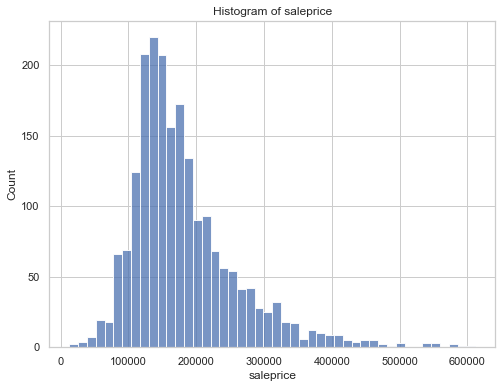

In [15]:
# histogram of saleprice
plt.figure(figsize=(8,6))
plt.title("Histogram of saleprice")
sns.histplot(ames_train['saleprice']);

Majority of **saleprice** values are in the left, i.e. saleprice has a positively skewed normal distribution. The right tail will be treated as outliers, and regression models are sensitive to outliers, so we will need to do a log transformation to normalise the data.

In [16]:
# Finding features with strong correlation with saleprice (>= 0.5)
ames_train[numeric_cols].corr()[ames_train[numeric_cols].corr()['saleprice'] > 0.5]['saleprice'].sort_values(ascending=False)

saleprice         1.000000
overall_qual      0.800207
gr_liv_area       0.697038
garage_area       0.650270
garage_cars       0.648220
total_bsmt_sf     0.628925
1st_flr_sf        0.618486
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
garage_yr_blt     0.533922
mas_vnr_area      0.512230
totrms_abvgrd     0.504014
Name: saleprice, dtype: float64

11 numerical features have a strong correlation (correlation >= 0.5) with saleprice. We'll take a closer look at each of these features

### overall_qual

**overall_qual** rates the overall material and finish of the house, and contains values on a scale of 1 to 10, with 1 being Very Poor and 10 being Very Excellent.

Mean: 6.1121404193076545
Standard deviation: 1.4262705424542637
Mode: 5
Median: 6.0
Max: 10
Min: 1


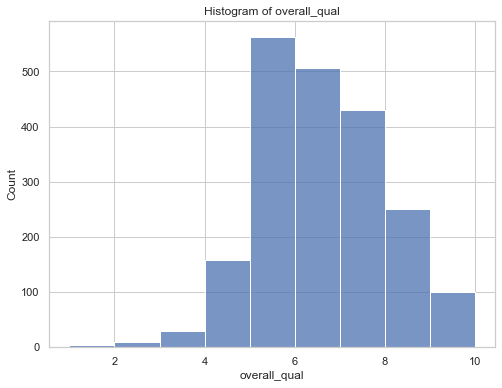

In [17]:
# Histogram of overall_qual
plt.figure(figsize=(8,6))
plt.title("Histogram of overall_qual")
sns.histplot(ames_train['overall_qual'],binwidth=1)

print_summary_stats('overall_qual')

The average **overall_qual** is 6.1 and the standard deviation is 1.43. This means that generally houses are in above average condition, and the spread of the **overall_qual** is not big.

Most of the houses in the data set has **overall_qual** = 5 and the median of 6 indicates that about half the houses have an **overall_qual** of 6 or above.

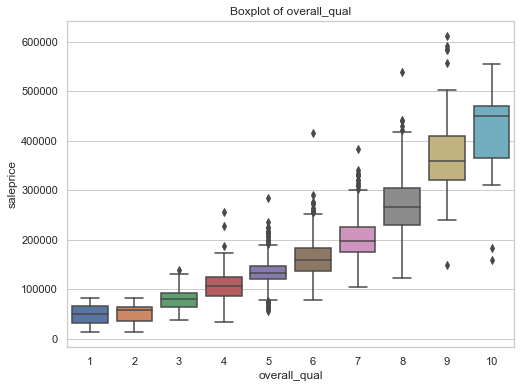

In [18]:
# Boxplot of overall_qual
boxplot_feature_vs_price('overall_qual')

The better the **overall_qual**, the higher the **saleprice**.

### gr_liv_area

**gr_liv_area** refers to above ground living area in square feet. 

Mean: 1499.330082886397
Standard deviation: 500.4478294652996
Mode: 864
Median: 1444.0
Max: 5642
Min: 334


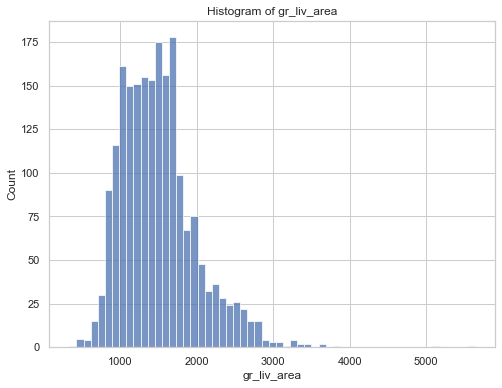

In [19]:
# Histogram of gr_liv_area
plt.figure(figsize=(8,6))
plt.title("Histogram of gr_liv_area")
sns.histplot(ames_train['gr_liv_area'])

print_summary_stats('gr_liv_area')

The average **gr_liv_area** is 1499.3 and the standard deviation is 500.4. Generally, houses have around 1,500 square feet of above-ground living area, and the spread of the **gr_liv_area** is not big.

The median and mean are close, indicating that the **gr_liv_area** is rather evenly distributed.

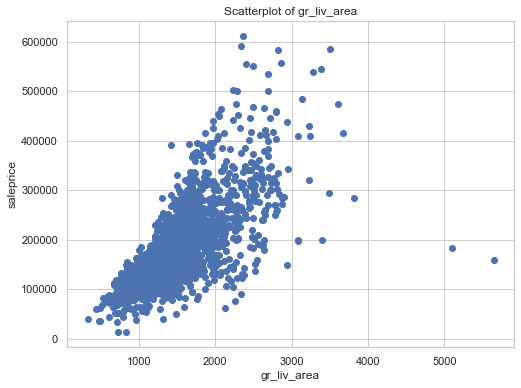

In [20]:
# gr_liv_area vs saleprice
scatterplot_feature_vs_price("gr_liv_area")

The larger the area, the higher the price. However, there seem to be 2 outliers with area greater than 5000 square feet but has a sale price less than \$200,000. We will drop these 2 records from the data set.

In [21]:
# keeping only data with gr_liv_area less than 5_000
ames_train = ames_train[ames_train["gr_liv_area"] < 5000]

### garage_area

**garage_area** refers to size of garage in square feet. 

Mean: 472.87841796875
Standard deviation: 214.5015429609319
Mode: 0.0
Median: 480.0
Max: 1356.0
Min: 0.0


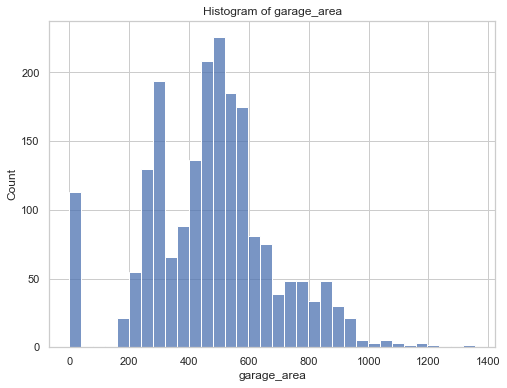

In [22]:
# Histogram of garage_area
plt.figure(figsize=(8,6))
plt.title("Histogram of garage_area")
sns.histplot(ames_train['garage_area'])

print_summary_stats('garage_area')

The average **garage_area** is 472.8 and the standard deviation is 214.5. This means that generally houses have a garage of around 472.8 square feet, and the spread of the **garage_area** is moderate.

The median and mean are close, indicating that the **garage_area** is rather evenly distributed.

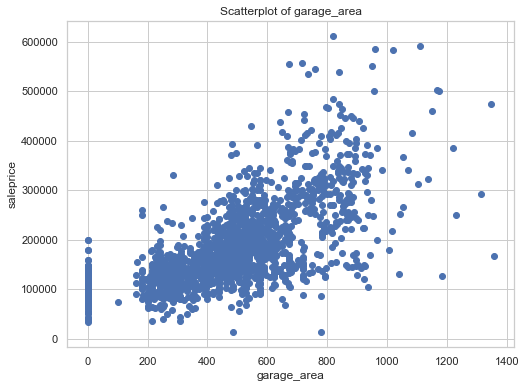

In [23]:
# garage_area vs saleprice
scatterplot_feature_vs_price("garage_area")

The larger the area, the higher the **saleprice**.

### garage_cars

**garage_cars** refers to the size of the garage in terms of car capacity. 

Mean: 1.77587890625
Standard deviation: 0.7644163771399974
Mode: 2.0
Median: 2.0
Max: 5.0
Min: 0.0


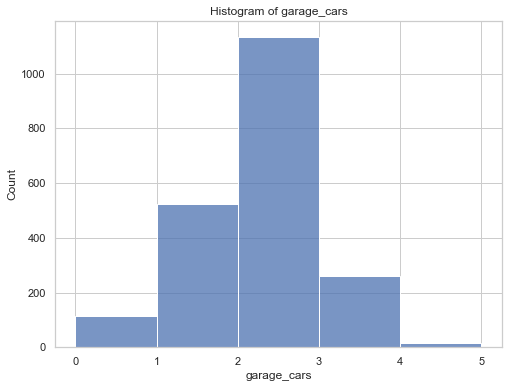

In [24]:
# Histogram of garage_cars
plt.figure(figsize=(8,6))
plt.title("Histogram of garage_cars")
sns.histplot(ames_train['garage_cars'],binwidth=1)

print_summary_stats('garage_cars')

The average **garage_cars** is 1.8 and the mode is 2. This means that generally houses with garages have space for 1 to 2 cars.

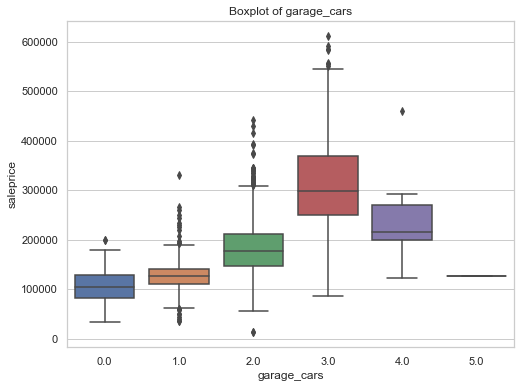

In [25]:
# Boxplot of garage_cars
boxplot_feature_vs_price('garage_cars')

There seems to be a trend where the higher **garage_cars** is, the higher **saleprice** will be. However, **saleprice** peaks at **garage_cars** = 3 and decreases there after. Optimum value seems to be 3.

As **garage_cars** and **garage_area** seem to be describing the same house feature, we will drop **garage_cars**, as it has a lower correlation with **Sale Price**, to reduce multicollinearity

In [26]:
ames_train.drop(columns = ["garage_cars"], inplace=True)
ames_test.drop(columns = ["garage_cars"], inplace=True)

### total_bsmt_sf

**total_bsmt_sf** refers to total square feet of basement area. 

Mean: 1053.5498046875
Standard deviation: 426.28343463455263
Mode: 0.0
Median: 994.0
Max: 3206.0
Min: 0.0


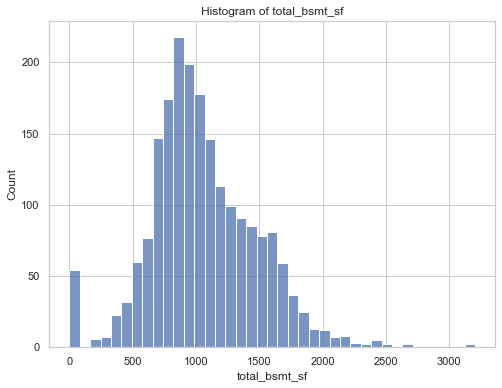

In [27]:
# Histogram of total_bsmt_sf
plt.figure(figsize=(8,6))
plt.title("Histogram of total_bsmt_sf")
sns.histplot(ames_train['total_bsmt_sf'])

print_summary_stats('total_bsmt_sf')

The average **total_bsmt_sf** is 1053.5 and the standard deviation is 426.3. This means that generally houses have a basement of around 1053.5 square feet, and the spread of the **total_bsmt_sf** is small.

The median and mean are close, indicating that the **total_bsmt_sf** is rather evenly distributed.

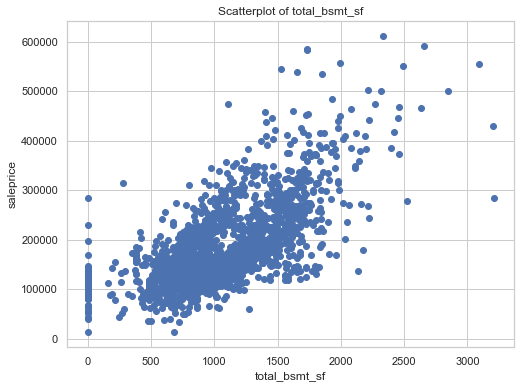

In [28]:
# total_bsmt_sf vs saleprice
scatterplot_feature_vs_price('total_bsmt_sf')

The larger the basement, the higher the **saleprice**.

### 1st_flr_sf

**1st_flr_sf** refers to the square feet of the first floor.

Mean: 1160.8482186432407
Standard deviation: 379.0661220689467
Mode: 864
Median: 1092.0
Max: 3820
Min: 334


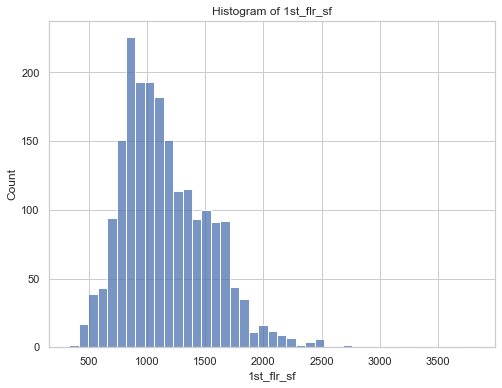

In [29]:
# histogram of 1st_flr_sf
plt.figure(figsize=(8,6))
plt.title("Histogram of 1st_flr_sf")
sns.histplot(ames_train['1st_flr_sf'])

print_summary_stats('1st_flr_sf')

The average **1st_flr_sf** is 1160.8 and the standard deviation is 379.1. This means that generally houses have a first floor of around 1160.8 square feet, and the spread of the **1st_flr_sf** is small.

The median and mean are close, indicating that the **1st_flr_sf** is rather evenly distributed.

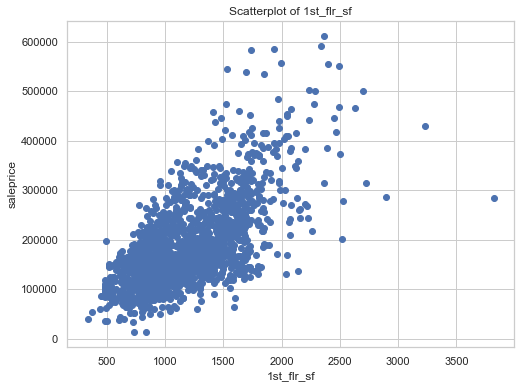

In [30]:
# 1st_flr_sf vs saleprice
scatterplot_feature_vs_price('1st_flr_sf')

The larger the first floor, the higher the **saleprice**.

### year_built

**year_built** refers to the original construction date

Mean: 1971.6734992679355
Standard deviation: 30.171292969287833
Mode: 2005
Median: 1974.0
Max: 2010
Min: 1872


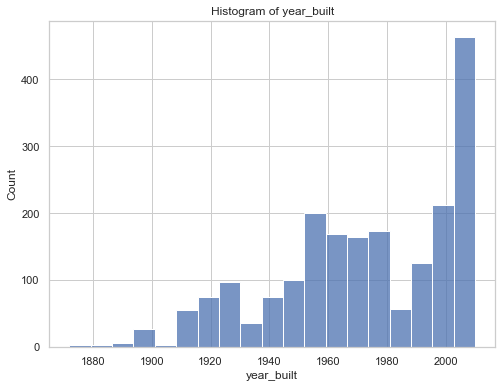

In [31]:
# histogram of year_built
plt.figure(figsize=(8,6))
plt.title("Histogram of year_built")
sns.histplot(ames_train['year_built'])

print_summary_stats('year_built')

The earliest house was constructed in 1872, and the most recent house was constructed in 2010 (as the data is up to 2010). 50% of the houses were constructed on or after 1974, and most of the houses were constructed in 2005.

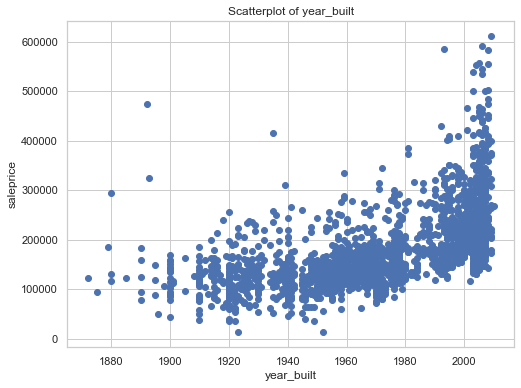

In [32]:
# year_built vs saleprice
scatterplot_feature_vs_price('year_built')

There is a slight upward trend where newer houses fetch a higher price.

### year_remod/add

**year_remod/add** refers to the remodel date. It will take the same value as **year_built** if no remodelling was done

Mean: 1984.1664226451928
Standard deviation: 21.032785162651233
Mode: 1950
Median: 1993.0
Max: 2010
Min: 1950


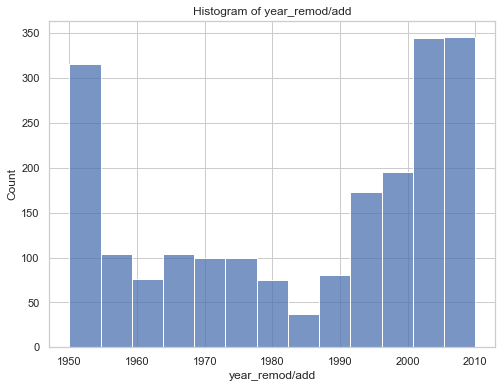

In [33]:
# histogram of year_remod/add
plt.figure(figsize=(8,6))
plt.title("Histogram of year_remod/add")
sns.histplot(ames_train['year_remod/add'])

print_summary_stats('year_remod/add')

The earliest remodelling was done in 1950. 50% of the houses were remodelled/built on or after 1993. Since there are no house with year_remod/add before 1950, it shows that all houses built before 1950 were eventually remodelled by 2010.

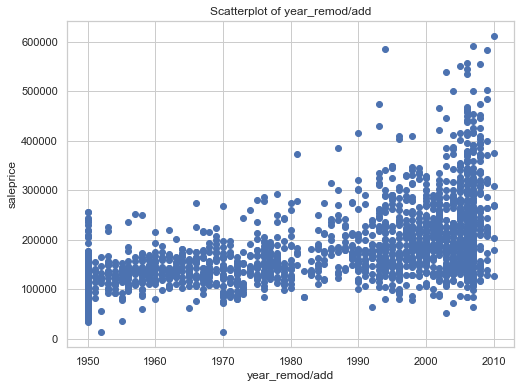

In [34]:
# year_built vs saleprice
scatterplot_feature_vs_price('year_remod/add')

There is a slight upward trend where recently remodelled houses fetch a higher price.

### full_bath

**full_bath** refers to the number of full bathrooms above ground. Full bath meaning it has a toilet, a sink, a shower and a bathtub. Half bath would mean that it only has a toilet and a sink.

Mean: 1.5768667642752563
Standard deviation: 0.5493886359880946
Mode: 2
Median: 2.0
Max: 4
Min: 0


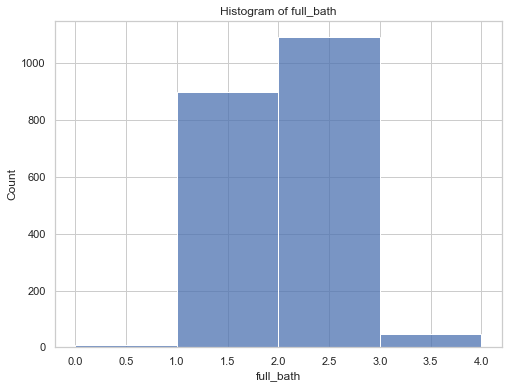

In [35]:
# histogram of full_bath
plt.figure(figsize=(8,6))
plt.title("Histogram of full_bath")
sns.histplot(ames_train['full_bath'],binwidth = 1)

print_summary_stats('full_bath')

The average **full_bath** is 1.6 and the standard deviation is 0.5. Generally, houses have 1-2 full baths.

Most of the houses in the data set has **full_bath** = 2 and the median of 2 indicates that about half the houses have an **full_bath** of 2 or above.

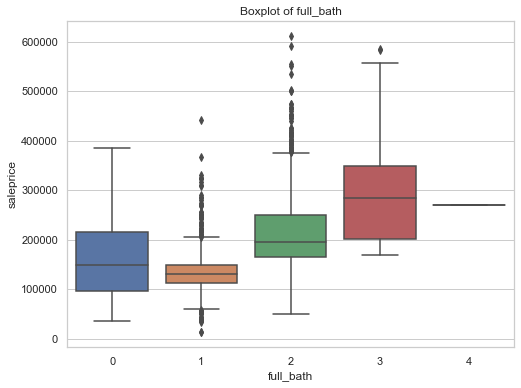

In [36]:
# Boxplot of full_bath
boxplot_feature_vs_price('full_bath')

The more full baths there are, the higher the **saleprice**.

### totrms_abvgrd

**totrms_abvgrd** refers to the total number of rooms above ground (excludes bathrooms)

Mean: 6.428989751098096
Standard deviation: 1.5445718347577666
Mode: 6
Median: 6.0
Max: 14
Min: 2


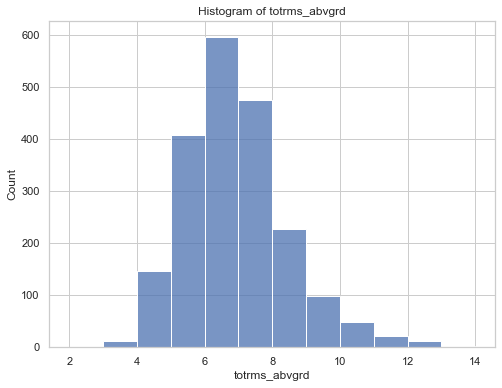

In [37]:
# histogram of totrms_abvgrd
plt.figure(figsize=(8,6))
plt.title("Histogram of totrms_abvgrd")
sns.histplot(ames_train['totrms_abvgrd'],binwidth = 1)

print_summary_stats('totrms_abvgrd')

The average **totrms_abvgrd** is 6.4 and the standard deviation is 1.5. This means that generally houses have about 6 rooms above ground.

Most of the houses in the data set has **totrms_abvgrd** = 6 and the median of 6 indicates that about half the houses have an **totrms_abvgrd** of 6 or above.

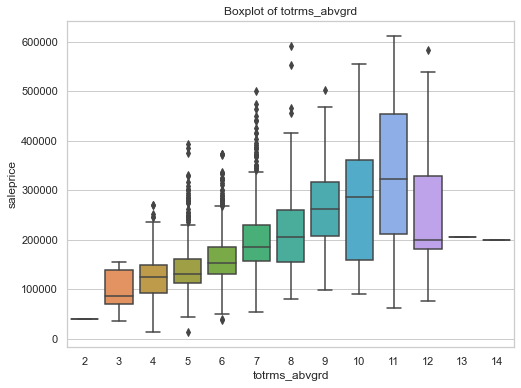

In [38]:
# Boxplot of totrms_abvgrd
boxplot_feature_vs_price('totrms_abvgrd')

There seems to be a trend where the higher **totrms_abvgrd** is, the higher **saleprice** will be. However, **saleprice** peaks at **totrms_abvgrd** = 11 and drops thereafter.

### mas_vnr_area

**mas_vnr_area** refers to masonry veneer area in square feet

Mean: 98.79773063640849
Standard deviation: 172.56384581741926
Mode: 0.0
Median: 0.0
Max: 1600.0
Min: 0.0


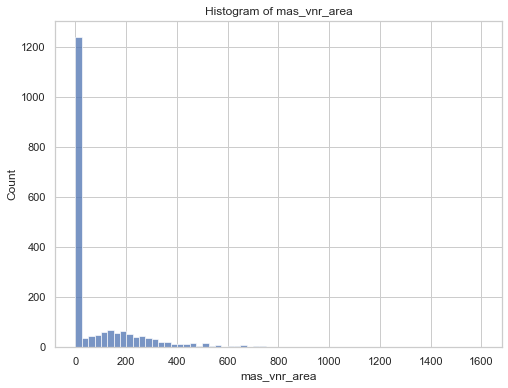

In [39]:
# histogram of mas_vnr_area
plt.figure(figsize=(8,6))
plt.title("Histogram of mas_vnr_area")
sns.histplot(ames_train['mas_vnr_area'])

print_summary_stats('mas_vnr_area')

The average **mas_vnr_area** is 98.8 and the standard deviation is 172.6. This means that generally houses have around 98.8 square feet of masonry veneer, and the spread of the **mas_vnr_area** is large.

Majority of values are 0, likely because most houses do not have masonry veneer.

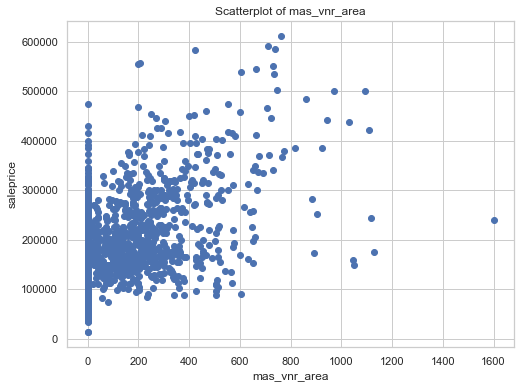

In [40]:
# mas_vnr_area vs saleprice
scatterplot_feature_vs_price('mas_vnr_area')

Generally, the larger the **mas_vnr_area**, the higher the price. However, there seems to be 1 outlier with area 1600 square feet but has a sale price less than \$300,000. We will drop this record from the data set.

In [41]:
# keeping only data with mas_vnr_area less than 1200
ames_train = ames_train[ames_train["mas_vnr_area"] < 1200]

In [42]:
# descriptive statistics of ames_train
ames_train.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_frontage,1702.0,68.821974,22.460744,21.0,58.00,68.0,80.00,313.0
lot_area,2026.0,10014.455084,6619.544232,1300.0,7500.00,9400.0,11488.75,159000.0
overall_qual,2026.0,6.094768,1.420799,1.0,5.00,6.0,7.00,10.0
overall_cond,2026.0,5.569595,1.108149,1.0,5.00,5.0,6.00,9.0
year_built,2026.0,1971.324284,30.143557,1872.0,1953.00,1973.0,2000.00,2010.0
year_remod/add,2026.0,1983.946199,21.037452,1950.0,1964.00,1993.0,2004.00,2010.0
mas_vnr_area,2026.0,98.056762,169.350359,0.0,0.00,0.0,160.00,1129.0
bsmtfin_sf_1,2025.0,437.411358,439.129045,0.0,0.00,368.0,732.00,2188.0
bsmtfin_sf_2,2025.0,48.404444,165.841681,0.0,0.00,0.0,0.00,1474.0
bsmt_unf_sf,2025.0,566.030617,444.499352,0.0,220.00,474.0,810.00,2336.0


In [43]:
# descriptive statistics of ames_test
ames_test.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_frontage,718.0,69.545961,23.533945,21.0,59.00,68.0,80.00,182.0
lot_area,878.0,10307.033030,10002.674602,1477.0,7297.25,9446.0,11589.00,215245.0
overall_qual,878.0,6.050114,1.369065,2.0,5.00,6.0,7.00,10.0
overall_cond,878.0,5.566059,1.128903,1.0,5.00,5.0,6.00,9.0
year_built,878.0,1970.492027,30.395895,1880.0,1954.00,1972.0,1999.75,2010.0
year_remod/add,878.0,1984.417995,20.450725,1950.0,1967.00,1992.0,2003.00,2010.0
mas_vnr_area,877.0,106.236032,187.158908,0.0,0.00,0.0,172.00,1378.0
bsmtfin_sf_1,878.0,441.328018,438.457329,0.0,0.00,373.0,734.75,2288.0
bsmtfin_sf_2,878.0,53.896355,178.632355,0.0,0.00,0.0,0.00,1526.0
bsmt_unf_sf,878.0,539.133257,426.172161,0.0,216.00,452.0,780.00,2046.0


Descriptive statistics for both ames_train and ames_test looks ok

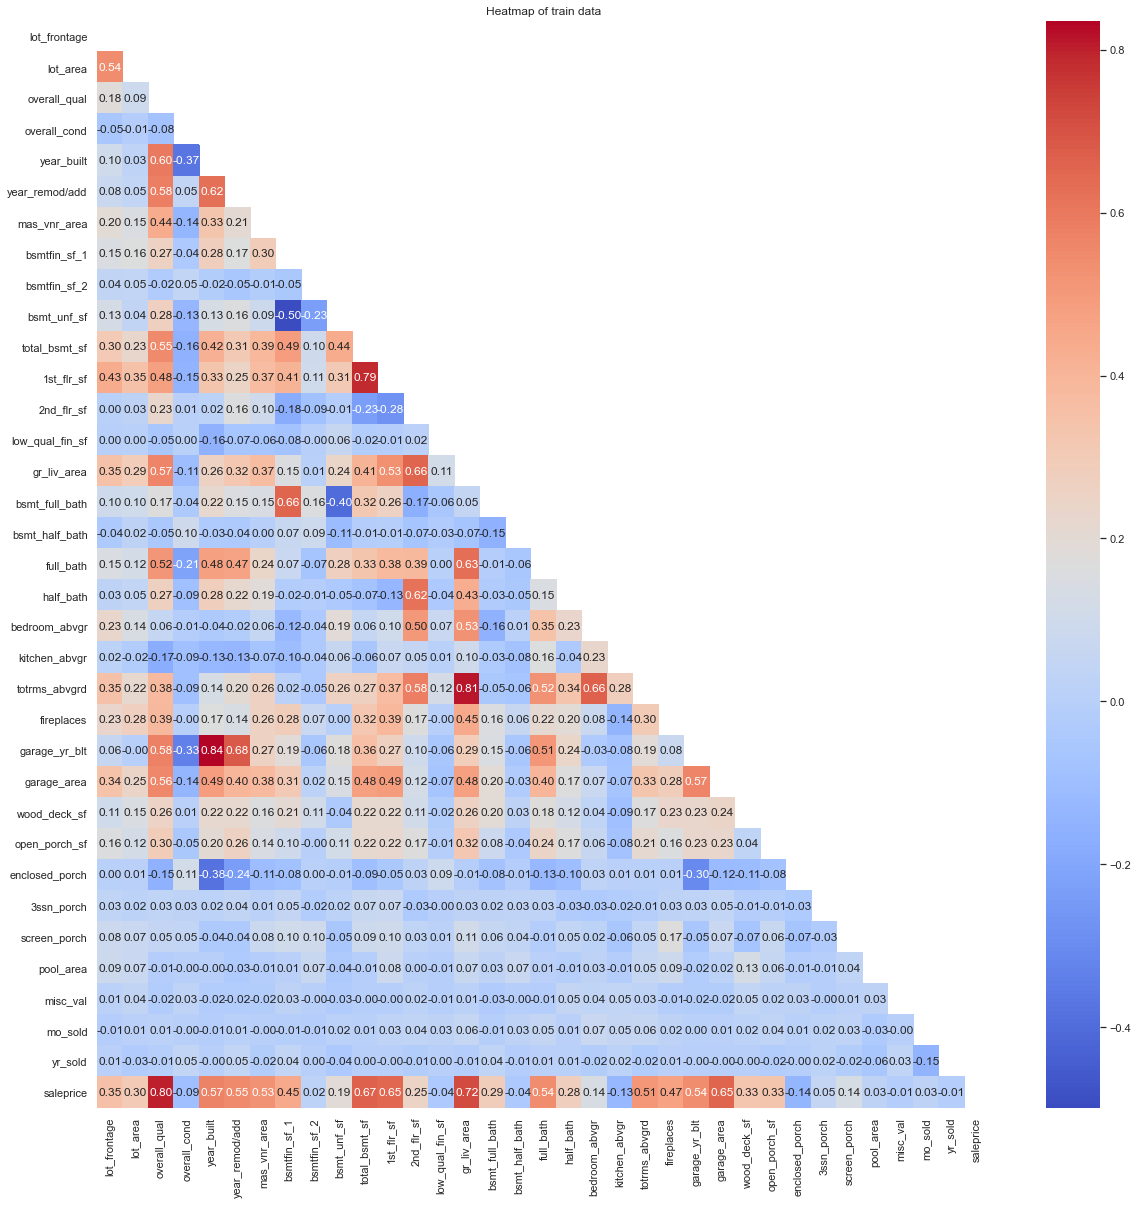

In [44]:
# creating mask to hide redundant values in heatmap
mask = np.zeros_like(ames_train.corr())
mask[np.triu_indices_from(mask)] = True

# defining figure size
plt.figure(figsize=(20,20))
plt.title("Heatmap of train data")

# plotting heatmap
sns.heatmap(
    ames_train.corr(),
    cmap = 'coolwarm',
    fmt='.2f',
    annot = True,
    mask = mask
);


There are 2 pairs of features that are highly correlated to each other: <br>
**garage_yr_blt** and **year_built** (correlation 0.84) <br>
**totrms abvegrd** and **gr_liv_area** (correlation 0.81) <br> 
**1st_flr_sf** and **total_bsmt_sf** (correlation 0.79)

This might suggest multicollinearity, so we will drop **garage_yr_blt**, **1st_flr_sf** and **totrms_abvgrd** as they have a lower correlation with **saleprice**

In [45]:
ames_train.drop(columns=['garage_yr_blt','1st_flr_sf','totrms_abvgrd'],inplace=True)
ames_test.drop(columns=['garage_yr_blt','1st_flr_sf','totrms_abvgrd'],inplace=True)

Generally, it seems the condition of the house and the size of the house in terms of square feet affects the sale price the most.

### Data Cleaning

In [46]:
print_cols_with_na(ames_train)
# list comprehension to get list of columns with null values
ames_train_cols_with_na = [col for col in ames_train if ames_train[col].isna().sum() > 0]
print(f"{len(ames_train_cols_with_na)} features in ames_train dataset have null values")

lot_frontage         324
alley                1889
bsmt_qual            55
bsmt_cond            55
bsmt_exposure        58
bsmtfin_type_1       55
bsmtfin_sf_1         1
bsmtfin_type_2       56
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
fireplace_qu         992
garage_type          112
garage_finish        113
garage_area          1
garage_qual          113
garage_cond          113
pool_qc              2018
fence                1626
misc_feature         1962
22 features in ames_train dataset have null values


In [47]:
print_cols_with_na(ames_test)
# list comprehension to get list of columns with null values
ames_test_cols_with_na = [col for col in ames_test if ames_test[col].isna().sum() > 0]
print(f"{len(ames_test_cols_with_na)} features in ames_test dataset have null values")

lot_frontage         160
alley                820
mas_vnr_type         1
mas_vnr_area         1
bsmt_qual            25
bsmt_cond            25
bsmt_exposure        25
bsmtfin_type_1       25
bsmtfin_type_2       25
electrical           1
fireplace_qu         422
garage_type          44
garage_finish        45
garage_qual          45
garage_cond          45
pool_qc              874
fence                706
misc_feature         837
18 features in ames_test dataset have null values


In [48]:
# combine lists of columns with na values
cols_with_na = ames_train_cols_with_na.copy()

for col_name in ames_test_cols_with_na:
    if col_name not in cols_with_na:
        cols_with_na.append(col_name)

In [49]:
numeric_cols_with_na = []
categoric_cols_with_na = []

# separating columns by whether they are categorical or numerical
for col_name in cols_with_na:
    if numerical_or_categorical(col_name) == "categorical":
        categoric_cols_with_na.append(col_name)
    elif numerical_or_categorical(col_name) == "numerical":
        numeric_cols_with_na.append(col_name)
    else: # to catch exceptions
        print("Neither categorical nor numerical. Check your data")

In [50]:
# categorical columns with NA values
categoric_cols_with_na

['alley',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'fireplace_qu',
 'garage_type',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'pool_qc',
 'fence',
 'misc_feature',
 'mas_vnr_type',
 'electrical']

Dealing with categorical columns first.

According to the data documentation, NA in these columns means the house does not have the respective feature: 
<li>alley
<li>bsmt_qual
<li>bsmt_cond
<li>bsmt_exposure
<li>bsmtfin_type_1
<li>bsmtfin_type_2
<li>fireplace_qu
<li>garage_type
<li>garage_finish
<li>garage_qual
<li>garage_cond
<li>pool_qc
<li>fence
<li>misc_feature
    
Therefore, we will replace the null values in these columns with "None"

We will need to look a little further into these 2 columns:
<li>mas_vnr_type
<li>electrical

In [51]:
cols_to_replace_with_none = ["alley","bsmt_qual","bsmt_cond","bsmt_exposure","bsmtfin_type_1","bsmtfin_type_2","fireplace_qu","garage_type","garage_finish","garage_qual","garage_cond","pool_qc","fence","misc_feature"]

In [52]:
# printing number and percentage of null values in mas_vnr_type in ames_train
print("ames_train")
print(f"mas_vnr_type has {ames_train['mas_vnr_type'].isna().sum()} null values")
print(f"{round(ames_train['mas_vnr_type'].isna().sum()/len(ames_train['mas_vnr_type']) * 100,2)}% of the column contains null values")
# print empty line for formatting
print()
# printing number and percentage of null values in mas_vnr_type in ames_test
print("ames_test")
print(f"mas_vnr_type has {ames_test['mas_vnr_type'].isna().sum()} null values")
print(f"{round(ames_test['mas_vnr_type'].isna().sum()/len(ames_test['mas_vnr_type']) * 100,2)}% of the column contains null values")

ames_train
mas_vnr_type has 0 null values
0.0% of the column contains null values

ames_test
mas_vnr_type has 1 null values
0.11% of the column contains null values


For **mas_vnr_type**, the data documentation does not mention that NA means None, but since the null values only account for a 1 record for ames_test, we will fill NA with "None".

In [53]:
# adding mas_vnr_type to cols_to_replace_with_none
cols_to_replace_with_none.append("mas_vnr_type")

In [54]:
# looping through cols_to_replace_with none
# to replace NA values in those columns with "None"
for col in cols_to_replace_with_none:
    if col in ames_train_cols_with_na:
        ames_train[col].fillna("None",inplace=True)
    
    if col in ames_test_cols_with_na:
        ames_test[col].fillna("None",inplace=True)

In [55]:
# printing number and percentage of null values in electrical in ames_train
print("ames_train")
print(f"electrical has {ames_train['electrical'].isna().sum()} null values")
print(f"{round(ames_train['electrical'].isna().sum()/len(ames_train['electrical']) * 100,2)}% of the column contains null values")
# print empty line for formatting
print()
# printing number and percentage of null values in electrical in ames_test
print("ames_test")
print(f"electrical has {ames_test['electrical'].isna().sum()} null values")
print(f"{round(ames_test['electrical'].isna().sum()/len(ames_test['electrical']) * 100,2)}% of the column contains null values")

ames_train
electrical has 0 null values
0.0% of the column contains null values

ames_test
electrical has 1 null values
0.11% of the column contains null values


For **electrical**, there is only 1 null value in ames_test. It is probably missing completely at random (MCAR). It would not make sense to replace the null value with "NONE" as it would not be applicable to this column. Instead, we will replace the null value with the most common value in **electrical**.

In [56]:
# get unique value counts for electrical column in ames_test
ames_test['electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

In [57]:
# get unique value counts for electrical column in ames_train
ames_train['electrical'].value_counts()

SBrkr    1843
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

SBrkr is the most common value for **electrical** for both ames_train and ames_test, so it should be fairly safe to replace the null value in **electrical** with "SBrkr".

In [58]:
# replace NA value with SBrkr
ames_test['electrical'].fillna("SBrkr",inplace=True)

Numerical columns next.

In [59]:
# numerical columns with NA values
numeric_cols_with_na

['lot_frontage',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'garage_area',
 'mas_vnr_area']

In [60]:
# print columns with NA values and their counts in ames_train and ames_test
print("ames_train")
print_cols_with_na(ames_train)
print()
print("ames_test")
print_cols_with_na(ames_test)

ames_train
lot_frontage         324
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
garage_area          1

ames_test
lot_frontage         160
mas_vnr_area         1


In [61]:
# list comprehension to get list of basement and garage features
basement_features = [col for col in ames_train if "bsmt" in col]
garage_features = [col for col in ames_train if "garage" in col]

Look at **Basement** features first. Only ames_train has na values in **bsmt** columns, so we will not be looking at ames_test

In [62]:
# filtering to NA value in bsmtfin_sf_1, showing all basement features
ames_train.loc[ames_train['bsmtfin_sf_1'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


In [63]:
# filtering to NA value in bsmtfin_sf_2, showing all basement features
ames_train.loc[ames_train['bsmtfin_sf_2'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


In [64]:
# filtering to NA value in bsmtfin_full_bath, showing all basement features
ames_train.loc[ames_train['bsmt_full_bath'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
616,None,None,None,None,0.0,None,0.0,0.0,0.0,NaN,NaN
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


In [65]:
# filtering to NA value in bsmtfin_half_bath, showing all basement features
ames_train.loc[ames_train['bsmt_half_bath'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
616,None,None,None,None,0.0,None,0.0,0.0,0.0,NaN,NaN
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


In [66]:
# filtering to NA value in total_bsmt_sf, showing all basement features
ames_train.loc[ames_train['total_bsmt_sf'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


In [67]:
# filtering to NA value in bsmt_unf_sf, showing all basement features
ames_train.loc[ames_train['bsmt_unf_sf'].isna(),basement_features]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1327,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN


Houses with null values in numerical features describing the basement do not have a basement, as the categorical columns are "None". We can fill na values for the **bsmt** numerical columns with 0.

In [68]:
basement_features_fill_zero = ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_full_bath','bsmt_half_bath','total_bsmt_sf','bsmt_unf_sf']

for col in basement_features_fill_zero:
    ames_train[col].fillna(0, inplace=True)

Looking at **garage** features next, for ames_train only as ames_test does not have NA values for **garage** features

In [69]:
ames_train.loc[(ames_train['garage_area'].isna()),garage_features]

,garage_type,garage_finish,garage_area,garage_qual,garage_cond
1712,Detchd,None,NaN,None,None


Similar to **bsmt** numerical columns, houses with null values in garage features describing the garage do not have a garage. There is 1 house with **garage_type** not "None", but other categorical columns are "None". We will assume that this house does not have a garage, and the data in **garage_type** was a data entry error. We will replace "Detchd" with "None. 
We will also fill NA values for **garage_area** numerical columns with 0.

In [70]:
# replace "Detchd" with "None" for this record
ames_train.loc[(ames_train["garage_type"] != "None") & (ames_train["garage_area"].isna()),"garage_type"] = "None"

In [71]:
# replace na values with 0 for garage_area
ames_train['garage_area'].fillna(0, inplace=True)

**mas_vnr_area** next, for ames_test only

In [72]:
ames_test.loc[ames_test['mas_vnr_area'].isna(),["mas_vnr_type","mas_vnr_area"]]

,mas_vnr_type,mas_vnr_area
865,None,NaN


The NA values in **mas_vnr_area** had a "None" value for **mas_vnr_type**. We will therefore fill the NA values in **mas_vnr_area** with 0

In [73]:
# fill na values of mas_vnr_area in ames_test with 0
ames_test["mas_vnr_area"].fillna(0,inplace=True)

Lastly, **lot_frontage**. The data documentation states that it means "Linear feet of street connected to property". In other words, it is the length of the property that is connected to the street that the property is on. Therefore, we should not fill the na values with 0 as it is unlikely for a property to not be connected to a street. Instead, we will impute values for **lot_frontage** with the mean value. 

For ames_train, as we will need to split the dataset into train and test data to prevent data leak, we will do the imputation at the last step.

For ames_test, we can impute it right away since the data set will not undergo train-test-split

In [74]:
# imputing NA with mean
ames_test['lot_frontage'].fillna(ames_test['lot_frontage'].mean(), inplace=True)

In [75]:
print("Columns with na in ames_train")
print_cols_with_na(ames_train)
print()
print("Columns with NA in ames_test:")
print_cols_with_na(ames_test)

Columns with na in ames_train
lot_frontage         324

Columns with NA in ames_test:
No NA values found in this dataframe


ames_train still has null values in **lot_frontage** as the NA values will be imputed with the mean values in X_train and X_test instead to prevent data leakage. We will do a train_test_split here (for exporting) to impute the mean for **lot_frontage** before exporting the cleaned version of ames_train as 2 separate files, 1) X_train and 2) X_test. 

We will repeat the train_test_split later (for modelling) after encoding the categorical and ordinal columns.

In [76]:
# train_test_split here to impute the mean of lot_frontage separately 
# for X_train_export and X_test_export to prevent data leakage
# random_state ensures that the train_test_split performed later on produces the same results as this train_test_split
X_train_export, X_test_export, y_train_export, y_test_export = train_test_split(ames_train.drop(columns=['saleprice']),ames_train['saleprice'],test_size=.2,random_state=123)

In [77]:
# imputing NA values in lot_frontage with mean of respective data set (prevents data leakage)
X_train_export['lot_frontage'].fillna(X_train_export['lot_frontage'].mean(),inplace=True)
X_test_export['lot_frontage'].fillna(X_test_export['lot_frontage'].mean(),inplace=True)

In [78]:
# adding back saleprice column for exporting
X_train_export['saleprice'] = y_train_export
X_test_export['saleprice'] = y_test_export

In [79]:
# Exporting cleaned ames_train
X_train_export.to_csv("../datasets/train_X_train_cleaned.csv", index=False)
X_test_export.to_csv("../datasets/train_X_test_cleaned.csv", index=False)

# Exporting cleaned ames_test
ames_test.to_csv("../datasets/test_cleaned.csv",index=False)

Next up is encoding ordinal and categorical columns.

In [80]:
# dictionaries for the value mapping of each feature base on data documentation
lot_shape_dict = {"IR3" : 0, "IR2" : 1, "IR1" : 2, "Reg" : 3}
util_dict = {"ELO" : 0, "NoSeWa" : 1, "NoSewr" : 2, "AllPub" : 3}
land_slope_dict = {"Sev": 0, "Mod" : 1, "Gtl" : 2}
exter_dict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
bsmt_qualcond_dict = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
bsmt_exposure_dict = {"None" : 0, "No" : 1, "Mn" : 2, "Av" : 3, "Gd" : 4}
bsmtfin_type_dict = {"None": 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
heating_qc_dict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
elec_dict = {"Mix" : 0, "FuseP" : 1, "FuseF" : 2, "FuseA" : 3, "SBrkr" : 4}
kitchen_qual_dict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
functional_dict = {"Sal" : 0, "Sev" : 1, "Maj2" : 2, "Maj1" : 3, "Mod" : 4, "Min2" : 5, "Min1" : 6, "Typ" : 7}
fireplace_qu_dict = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
garage_finish_dict = {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3}
garage_qualcond_dict = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
paved_drive_dict = {"N" : 0, "P" : 1, "Y" : 2}
pool_qc_dict = {"None" : 0,  "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
fence_dict = {"None" : 0, "MnWw" : 1, "GdWo" : 2, "MnPrv" : 3, "GdPrv" : 4}

In [81]:
# custom function to encode ordinal columns
# as the same encoding has to be done for 2 separate datasets, ames_train and ames_test
def encode_ordinal_columns(df):
    df['lot_shape'] = df['lot_shape'].map(lot_shape_dict)
    df['utilities'] = df['utilities'].map(util_dict)
    df['land_slope'] = df['land_slope'].map(land_slope_dict)
    df['exter_qual'] = df['exter_qual'].map(exter_dict)
    df['exter_cond'] = df['exter_cond'].map(exter_dict)
    df['bsmt_qual'] = df['bsmt_qual'].map(bsmt_qualcond_dict)
    df['bsmt_cond'] = df['bsmt_cond'].map(bsmt_qualcond_dict)
    df['bsmt_exposure'] = df['bsmt_exposure'].map(bsmt_exposure_dict)
    df['bsmtfin_type_1'] = df['bsmtfin_type_1'].map(bsmtfin_type_dict)
    df['bsmtfin_type_2'] = df['bsmtfin_type_2'].map(bsmtfin_type_dict)
    df['heating_qc'] = df['heating_qc'].map(heating_qc_dict)
    df['electrical'] = df['electrical'].map(elec_dict)
    df['kitchen_qual'] = df['kitchen_qual'].map(kitchen_qual_dict)
    df['functional'] = df['functional'].map(functional_dict)
    df['fireplace_qu'] = df['fireplace_qu'].map(fireplace_qu_dict)
    df['garage_finish'] = df['garage_finish'].map(garage_finish_dict)
    df['garage_qual'] = df['garage_qual'].map(garage_qualcond_dict)
    df['garage_cond'] = df['garage_cond'].map(garage_qualcond_dict)
    df['paved_drive'] = df['paved_drive'].map(paved_drive_dict)
    df['pool_qc'] = df['pool_qc'].map(pool_qc_dict)
    df['fence'] = df['fence'].map(fence_dict)

In [82]:
encode_ordinal_columns(ames_train)
encode_ordinal_columns(ames_test)

In [83]:
# Defining target variable as we will be dropping saleprice from ames_train during the concatenation of ames_train and ames_test
# We log-transform saleprice to normalise the data as it has a positive skew
y = np.log(ames_train['saleprice'])

# Creating a copy of ames_test id column before it gets dropped during the combining of dataframes for the kaggle submission
ames_test_id = ames_test['id']

# getting the index marker for ames_train for splitting ames_train and ames_test after encoding
ames_train_idx_marker = len(ames_train)

# Combining ames_train and ames_test to do dummy encoding before splitting them again
# Dropping id and pid for both ames_train and ames_test as they are identification numbers and do not describe a feature of the house
# Dropping saleprice for ames_train as it is the target variable
combine_ames_train_test = pd.concat([ames_train.drop(columns=['id','pid','saleprice']), ames_test.drop(columns=['id','pid'])], axis=0)

# dummy encoding of categorical columns
combine_ames_train_test = pd.get_dummies(combine_ames_train_test, drop_first = True)

In [84]:
# splitting the dataframe back into ames_train and ames_test after dummy encoding
ames_train_encoded = combine_ames_train_test[:ames_train_idx_marker]
ames_test_encoded = combine_ames_train_test[ames_train_idx_marker:]

In [85]:
# train_test_split here to impute the mean of lot_frontage separately 
# for X_train and X_test to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(ames_train_encoded,y,test_size=.2,random_state=123)

In [86]:
# Creating a list of column headers as StandardScaler will change X_train into an aray
X_columns = X_train.columns

In [87]:
# Imputing NA values in lot_frontage with mean of respective data set (prevents data leakage)
X_train['lot_frontage'].fillna(X_train['lot_frontage'].mean(),inplace=True)
X_test['lot_frontage'].fillna(X_test['lot_frontage'].mean(),inplace=True)

C:\Users\Internet\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Warning is telling us we are setting values on a copy of a slice of a DataFrame, which is exactly what we are doing to X_train and X_test as we want to prevent data leakage, so we can ignore the warning.

In [88]:
print("Columns with na in X_train")
print_cols_with_na(X_train)
print()
print("Columns with na in X_test")
print_cols_with_na(X_test)

Columns with na in X_train
No NA values found in this dataframe

Columns with na in X_test
No NA values found in this dataframe


No more na values.

<a id = "modelling"></a>

Modelling
---

#### Preprocessing and Modeling

<li>Are categorical variables one-hot encoded?
<li>Does the student investigate or manufacture features with linear relationships to the target?
<li>Have the data been scaled appropriately?
<li>Does the student properly split and/or sample the data for validation/training purposes?
<li>Does the student utilize feature selection to remove noisy or multi-collinear features?
<li>Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: linear regression, lasso, and ridge)?
<li>Does the student defend their choice of production model relevant to the data at hand and the problem?
<li>Does the student explain how the model works and evaluate its performance successes/downfalls?

In [89]:
# Scaling the data with StandardScaler
# To be used in linear, lasso and ridge regression
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Baseline Model: Linear Regression

In [90]:
# Instantiating LinearRegression
lr = LinearRegression()

In [91]:
# Fitting X_train and y_train to LinearRegression model
lr.fit(X_train, y_train);

In [92]:
# LinearRegression train score
print(f"LinearRegression train score: {lr.score(X_train, y_train)}")

#LinearRegression test score
print(f"LinearRegression test score: {lr.score(X_test, y_test)}")

LinearRegression train score: 0.944527520191999
LinearRegression test score: -1278471781445.817


For the baseline model, we are using a simple Linear Regression model without regularisation.

While the train score is good (0.944), the test score is a large negative number. This means that the model does not respond well to the test data, so there is overfitting of the train data. This model, while being able to predict the saleprice of the train data to a great extent, is unable to predict the saleprice of the test data correctly, and will not be a good model for future datasets.

In [93]:
lr_train_scores = cross_val_score(lr, X_train, y_train, cv=5)
lr_test_scores = cross_val_score(lr, X_test, y_test, cv=5)
print(f"Average LinearRegression train cross-validated score: {lr_train_scores.mean()}")
print(f"Average LinearRegression test cross-validated score: {lr_test_scores.mean()}")

Average LinearRegression train cross-validated score: -9.097758738552222e+21
Average LinearRegression test cross-validated score: -4.166215402518819e+23


The cross-validated train score is also a large negative number. This means that the high train score from earlier was merely a fluke, and that the model is not suitable for use. We will not be calculating the RMSE to evaluate the LinearRegression model since it is clear that this model is not suitable.

There is a need to regularize the model using Ridge or Lasso regression.

### Regularized Model: Ridge Regression

In [94]:
# using RidgeCV to find the optimal alpha for the Ridge regression
ridge_cv = RidgeCV(alphas = np.linspace(.1,100,1000)).fit(X_train, y_train)

In [95]:
print(f"Optimal Ridge alpha: {ridge_cv.alpha_}")

Optimal Ridge alpha: 96.2


In [96]:
# Putting optimal alpha value from RidgeCV into Ridge to reduce runtime when performing cross_val_score
ridge_model = Ridge(alpha=ridge_cv.alpha_, random_state=123)
ridge_model.fit(X_train, y_train)

print(f"Ridge train score: {ridge_model.score(X_train, y_train)}")
print(f"Ridge test score: {ridge_model.score(X_test, y_test)}")

Ridge train score: 0.9387100182279389
Ridge test score: 0.9002461032244252


Train and test scores are extremely high (> 0.9)

### Regularized Model: Lasso Regression

In [97]:
# using LassoCV to find the optimal alpha for the Ridge regression
lasso_cv = LassoCV(alphas = np.logspace(-3,0,1000), max_iter = 10000, random_state = 123).fit(X_train, y_train)

In [98]:
print(f"Optimal Lasso alpha: {lasso_cv.alpha_}")

Optimal Lasso alpha: 0.003424006137971426


In [99]:
# Putting optimal alpha value from LassoCV into Lasso to reduce runtime when performing cross_val_score
lasso_model = Lasso(alpha = lasso_cv.alpha_,  max_iter=50000)
lasso_model.fit(X_train, y_train)

print(f"Lasso train score: {lasso_model.score(X_train, y_train)}")
print(f"Lasso test score: {lasso_model.score(X_test, y_test)}")

Lasso train score: 0.931395393892055
Lasso test score: 0.9034118226801416


Train and test scores are extremely high (> 0.9)

<a id = "eval"></a>

Evaluation
---

In [100]:
def print_scores(model):
    print(f"Train score: {model.score(X_train,y_train)}")
    print(f"Test score: {model.score(X_test,y_test)}")
    print(f"Average cross-validated train score: {cross_val_score(model,X_train,y_train,cv=5).mean()}")
    print(f"Average cross-validated test score: {cross_val_score(model,X_test,y_test,cv=5).mean()}")

We will evaluate the models by calculating the Root Mean Squared Error (RMSE) and examining the residuals.

As established earlier, the baseline model is not suitable for use, and the cross-validated scores are large negative numbers. We will go ahead and evaluate the ridge and lasso regression models.

### Ridge regression model evaluation

In [101]:
# Predicting values with Ridge model using X_test
y_pred_ridge = ridge_model.predict(X_test)

In [102]:
# Getting RMSE of Ridge model
# y_test and y_pred_ridge transformed back for the RMSE to make sense
ridge_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test),np.exp(y_pred_ridge)))
print(f"RMSE of Ridge model: {ridge_rmse}")

RMSE of Ridge model: 18684.4546413025


RMSE of 18684 means that the predictions of the model are about \$18,684 away from the actual value. Considering that the range of **saleprice** goes up to \$600,000, this model is able to predict house prices quite accurately.

In [103]:
print("=====Ridge model scores=====")
print_scores(ridge_model)

=====Ridge model scores=====
Train score: 0.9387100182279389
Test score: 0.9002461032244252
Average cross-validated train score: 0.9086134619220976
Average cross-validated test score: 0.8780260080409489


Ridge model train & test and cross-validated scores are very high. We can conclude that this model is representative for future data.

### Lasso regression model evaluation

In [104]:
# Predicting values with Ridge model using X_test
y_pred_lasso = lasso_model.predict(X_test)

In [105]:
# Getting RMSE of Ridge model
# y_test and y_pred_ridge transformed back for the RMSE to make sense
lasso_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test),np.exp(y_pred_lasso)))
print(f"RMSE of Lasso model: {lasso_rmse}")

RMSE of Lasso model: 18769.719439219407


RMSE of 18769 means that the predictions of the model are about \\$18,769 away from the actual value. Considering that the range of **saleprice** goes up to $600,000, this model is also able to predict house prices quite accurately.

In [106]:
print("=====Lasso model scores=====")
print_scores(lasso_model)

=====Lasso model scores=====
Train score: 0.931395393892055
Test score: 0.9034118226801416
Average cross-validated train score: 0.9131448701101897
Average cross-validated test score: 0.8805481418034645


Lasso model train & test and cross-validated scores are very high. We can conclude that this model is representative for future data.

### Model selected: Lasso regression model

| Model                      | 5-fold  Cross-Validated Train score | 5-fold  Cross-Validated Test score | Root Mean  Square Error |
|----------------------------|-------------------------------------|------------------------------------|-------------------------|
| Baseline/Linear regression | -9.10e21                            | -4.17e23                           | NA                      |
| Ridge regression           | 0.909                               | 0.878                              | 18684.45                |
| Lasso regression           | 0.913                               | 0.881                              | 18769.72                |

Both the ridge and lasso models look promising. The ridge model has a lower RMSE, but the lasso model has higher cross-validated scores. We will choose to utilise the lasso model even though it has a higher RMSE than the ridge model. The lasso model is able to remove unimportant features from the model and it has a higher accuracy which means it should be more representative for future data.

### Predicted vs Actual values plot

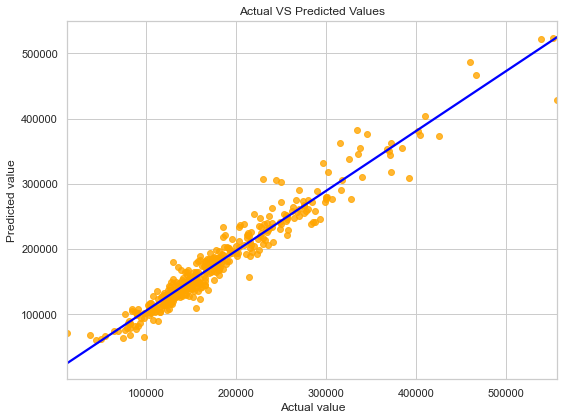

In [107]:
plt.figure(figsize=(8,6))
sns.regplot(x = np.exp(y_test), y = np.exp(y_pred_lasso), color = 'orange',line_kws={'color':'blue'}, ci=None)
plt.title('Actual VS Predicted Values')
plt.ylabel('Predicted value')
plt.xlabel('Actual value');

From this plot of actual vs predicted, we can see that the model is able to predict the values well, but it is not perfect. It does extremely well in predicting sale prices between around \\$75,000 to around \$300,000, but does not do as well in predicting sale prices past \\$300,000

###  Residuals vs Predicted values plot

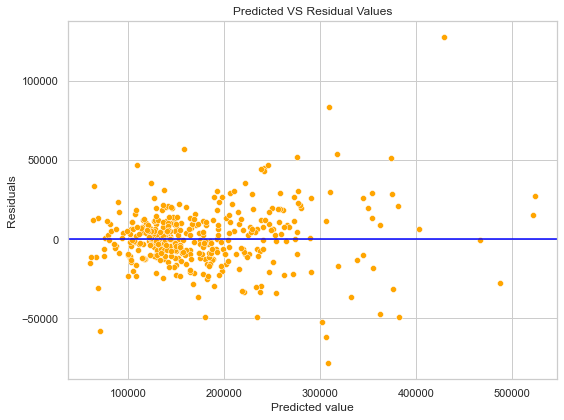

In [108]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = np.exp(y_pred_lasso), y = np.exp(y_test) - np.exp(y_pred_lasso), color = 'orange')
plt.axhline(0, color = 'blue')
plt.title('Predicted VS Residual Values')
plt.ylabel('Residuals')
plt.xlabel('Predicted value');

The residual vs predicted plot further supports the observations made after analysing the predicted vs actual plot. The model performs best predicting values between around \\$75,000 and \\$300,000, and the residuals go further away past \$300,000.

### Lasso regression coefficients

In [109]:
# Creating DataFrame of feature's coefficients
lasso_coef = pd.DataFrame({'feature':X_columns,'coefficient':lasso_model.coef_})

# Transforming coefficients for interpretation
lasso_coef['coefficient'] = (lasso_coef['coefficient'].apply(np.exp)-1) * np.mean(np.exp(y_train))

In [110]:
print(f"Lasso model has {np.sum(lasso_model.coef_ != 0)} features remaining. {len(lasso_model.coef_)-np.sum(lasso_model.coef_ != 0)} features were removed.")

Lasso model has 88 features remaining. 124 features were removed.


In [111]:
# print best 5 coefficients
lasso_coef.sort_values('coefficient',ascending=False).head()

,feature,coefficient
25,gr_liv_area,24955.560652
5,overall_qual,15303.409107
7,year_built,9829.999203
6,overall_cond,7073.312571
16,bsmtfin_sf_1,6324.795711


As predicted during our analysis, the 5 features that positively affect **saleprice** the most are highly correlated with **saleprice**: <br>
**Gr Liv Area** <br>
**Overall Qual** <br>
**Year Built** <br>
**Overal Cond** <br>
**BsmtFin SF 1**

Essentially a large house with good quality and in good condition will fetch a higher house price.

In [112]:
# print worst 5 coefficients
lasso_coef.sort_values('coefficient',ascending=False).tail()

,feature,coefficient
139,roof_style_Mansard,-1617.614183
95,neighborhood_MeadowV,-1737.858566
53,ms_subclass_160,-1858.775350
191,heating_Wall,-2072.297865
67,ms_zoning_C (all),-3037.589607


These are the 5 features that negatively affect **saleprice** the most: <br>
**Roof Style**, specifically Mansard<br>
**Neighborhood**, specifically Meadow Village <br>
**MS SubClass**, specifically 2-storey planned unit development, built in 1946 or after<br>
**Heating**, specifically Wall Furnace<br>
**MS Zoning**, specifically Commercial

We may want to avoid these specific features to avoid bringing down the house price

<a id = "conclusion"></a>

Conclusion & Recommendation
---

The model we trained is able to predict the sale price of houses within \\$18,769.72. The model does well in predicting sale prices between \\$75,000 and \$300,000. If there is a need to predict prices outside of that range, the model will need to be improved by either providing more training data with prices outside of the range or implementing other models/modelling techniques.

Based on the selected model, we are able to find out the 5 features that positively affects the sale price the most and the 5 features that negatively affects the sale price the most based on the coefficients of the model. The interpretation of the coefficient is as follows: 

Holding everything else constant,<br><ul>
<li>For every unit increase in squarefeet of **Gr Liv Area**, the sale price will <span style="color:green"><b>increase</b></span> by \$24,955.56<br>
<li>For each grade increase in **Overall Qual**, the sale price will  <span style="color:green"><b>increase</b></span> by \$15303.41 <br>
<li>For each unit increase in **Year Built**, the sale price will  <span style="color:green"><b>increase</b></span> by \$9830.00 <br>
<li>For each grade increase in **Overal Cond**, the sale price will  <span style="color:green"><b>increase</b></span> by \$7073.31 <br>
<li>For every unit increase in squarefeet of **BsmtFin SF 1**, the sale price will  <span style="color:green"><b>increase</b></span> by \$6324.80 <br>
<li>Having the house zoned as Commercial in **MS Zoning**, will <span style="color:red"><b>decrease</b></span> the sale price by \$3037.59 <br>
<li>Having Wall Furnace **Heating**, will <span style="color:red"><b>decrease</b></span> the sale price by \$2072.30 <br>
<li>Having the class categorised in **MS SubClass** as a 2-storey planned unit development (PUD), built in 1946 or after, will <span style="color:red"><b>decrease</b></span> the sale price by \$1858.78 <br>
<li>Having the house in Meadow Village **Neighborhood**, will <span style="color:red"><b>decrease</b></span> the sale price by \$1737.86 <br>
<li>Having Mansard **Roof Style**, will <span style="color:red"><b>decrease</b></span> the sale price by \$1617.61
</ul><br>

Therefore, for the Bluth Company to maximise revenue, they should develop a property that is/has: <br>
<ul><li>Spacious/large (i.e. large above ground living area, and large finished basement)
<li>Excellent quality
<li>In excellent condition
<li>Built recently (if remodelling)
<li>Non-commercial
</ul>
They should also avoid:
<ul>
<li> Mansard roofs
<li> Wall furnace heating
<li> 2-storey PUD, built in 1946 or after
<li> Meadow Village
</ul>

<a id ="kaggle"></a>

For Kaggle submission
---

In [113]:
# scaling ames_test
Z_ames_test = ss.transform(ames_test_encoded)

In [114]:
# Predicting values with Ridge model
y_pred_ames_test = lasso_model.predict(Z_ames_test)

In [115]:
# creating empty dataframe
output = pd.DataFrame()

In [116]:
# filling output df with id and saleprice
output['Id'] = ames_test_id
output['SalePrice'] = np.exp(y_pred_ames_test)

In [117]:
# export to csv
output.to_csv("../datasets/submission.csv",index=False)

<img src="../images/kaggle_score.png">